# Import modules

In [1]:
from diced import DicedStore
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

%matplotlib inline

In [2]:
store = DicedStore("gs://flyem-public-connectome")
repo = store.open_repo("medulla7column")
grayscale = repo.get_array("grayscale")
groundtruth = repo.get_array("groundtruth")

# Save and load

In [3]:
import pickle

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def save_object(input_object):
    name = namestr(input_object, globals())[0]
    with open('./save/' + name + '.dmp', 'wb') as f:
        pickle.dump(input_object, f)
        
def load_object(input_object):
    name = namestr(input_object, globals())[0]
    with open('./save/' + name + '.dmp', 'r') as f:
        loaded_f = pickle.load(f)
    return loaded_f

# Get some chunk of array from the index in roi.json

In [4]:
with open('./json_repo/roi.json', 'r') as f:
    data = json.load(f)
    
roi = np.array(data) * 32
roi

array([[1696, 2464, 3232, 4768],
       [1696, 2496, 3232, 4768],
       [1696, 2528, 3232, 4768],
       ..., 
       [7744, 3392, 2080, 3648],
       [7744, 3424, 2080, 3648],
       [7744, 3456, 2080, 3648]])

In [5]:
# Get voxel coordinates from the roi which is densely proofread segmentation
z_start = roi[0, 0]
z_end = z_start + 32
y_start = roi[0, 1]
y_end = y_start + 32
x_start_from = roi[0, 2]
x_end_from = x_start_from
x_start_to = roi[0, 3]
x_end_to = x_start_to

In [6]:
z_start, z_end, y_start, y_end, x_start_from,x_end_from

(1696, 1728, 2464, 2496, 3232, 3232)

In [7]:
chunk_gry = grayscale[z_start:z_end, y_start:y_end, x_start_from:x_end_to]
chunk_gt = groundtruth[z_start:z_end, y_start:y_end, x_start_from:x_end_to]

In [8]:
chunk_gry.shape

(32, 32, 1536)

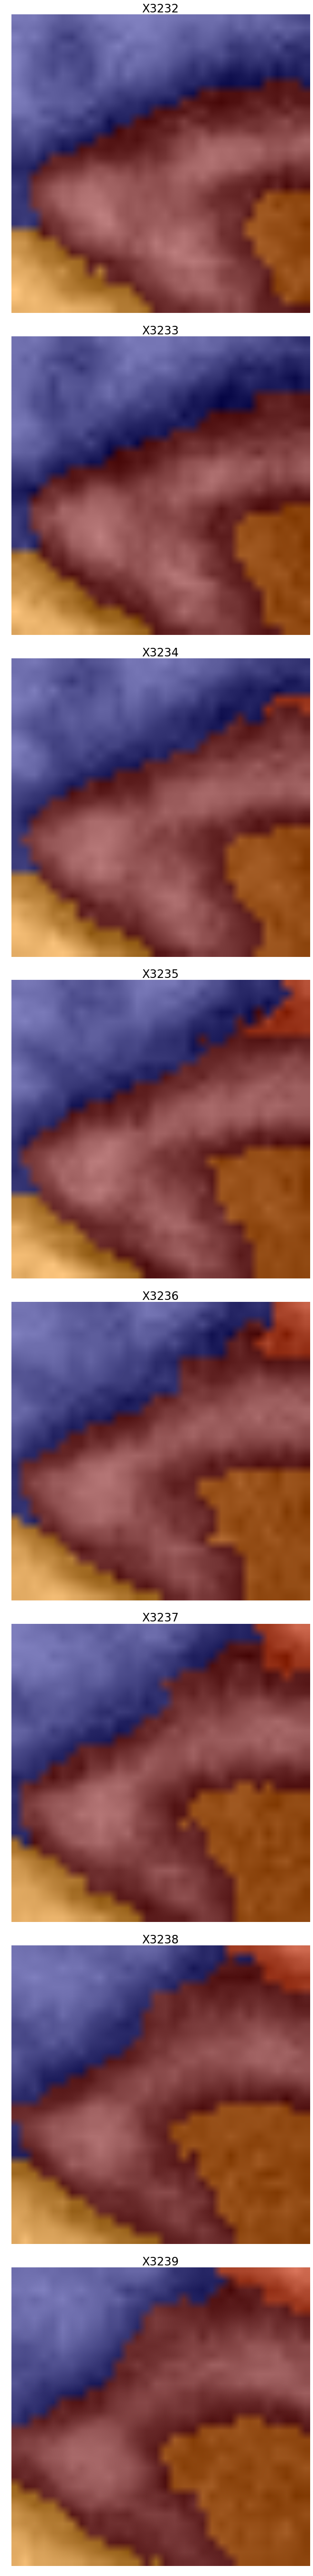

In [9]:
# Plotting several images from the array
plt.figure(figsize=(75, 75))

pic_num = 8   # <-- change the value like 1 ~ 31 
if pic_num < 4:
    pic_num_even = pic_num
    pic_num_odd = 1
else:
    pic_num_even = pic_num // 2
    pic_num_odd = pic_num // 2 + (pic_num % 2)

for i in range(pic_num):
#     plt.subplot(pic_num_even, pic_num_odd, i+1)
    plt.subplot(pic_num_even + pic_num_odd, 1, i+1)
    plt.imshow(chunk_gry[:, :, i * 1], cmap='gray')
    plt.imshow(chunk_gt[:, :, i * 1], alpha=0.5)
    plt.axis('off')
    plt.title('X{}'.format(x_start_from + i), fontsize=24)
    
plt.tight_layout()
plt.show()

# Where is synapse?

In [10]:
with open('./json_repo/synapse.json', 'r') as fsyn:
    synapse = json.load(fsyn)

In [11]:
# check T-bar's location 
print("-----------3 units of T-bar location-----------")
for idx in range(3):
    print(dict(synapse['data'][idx])['T-bar']['location'])
print("------------------------------------ -----------")


# make dictionary like {(body id_1, location_1), (body id_1, location_1)..}
synapse_with_body_id = []
syn_len = len(synapse['data'])

if os.path.exists("./save/synapse_with_body_id.dmp"):
    synapse_with_body_id = load_object(synapse_with_body_id)
    print("complete loading synapse_with_body_id")
else:
    for idx in range(syn_len):
        tmp_tuple = (dict(synapse['data'][idx])['T-bar']['body ID'], 
                     dict(synapse['data'][idx])['T-bar']['location'])
        synapse_with_body_id.append(tmp_tuple)
    synapse_with_body_id = dict(synapse_with_body_id)
    save_object(synapse_with_body_id)
    print("complete saving synapse_with_body_id")

-----------3 units of T-bar location-----------
[1858, 2225, 6584]
[1859, 2181, 6696]
[1860, 2525, 6152]
------------------------------------ -----------
complete loading synapse_with_body_id


# Get synapse_list by body_id

In [12]:
body_id_list = synapse_with_body_id.keys()
idx = 0  # <-- change the idx value like 0,1,2,3...
print("body_id_list[{}]".format(idx))

syn_x = synapse_with_body_id[body_id_list[idx]][0]
syn_y = synapse_with_body_id[body_id_list[idx]][1]
syn_z = synapse_with_body_id[body_id_list[idx]][2]
print("syn_x: %d, syn_y: %d, syn_z: %d"%(syn_x, syn_y, syn_x))

body_id_list[0]
syn_x: 4383, syn_y: 1739, syn_z: 4383


In [13]:
syn_gry = grayscale[syn_z:syn_z+32, syn_y:syn_y+32, syn_x:syn_x+32]
syn_gt = groundtruth[syn_z:syn_z+32, syn_y:syn_y+32, syn_x:syn_x+32]

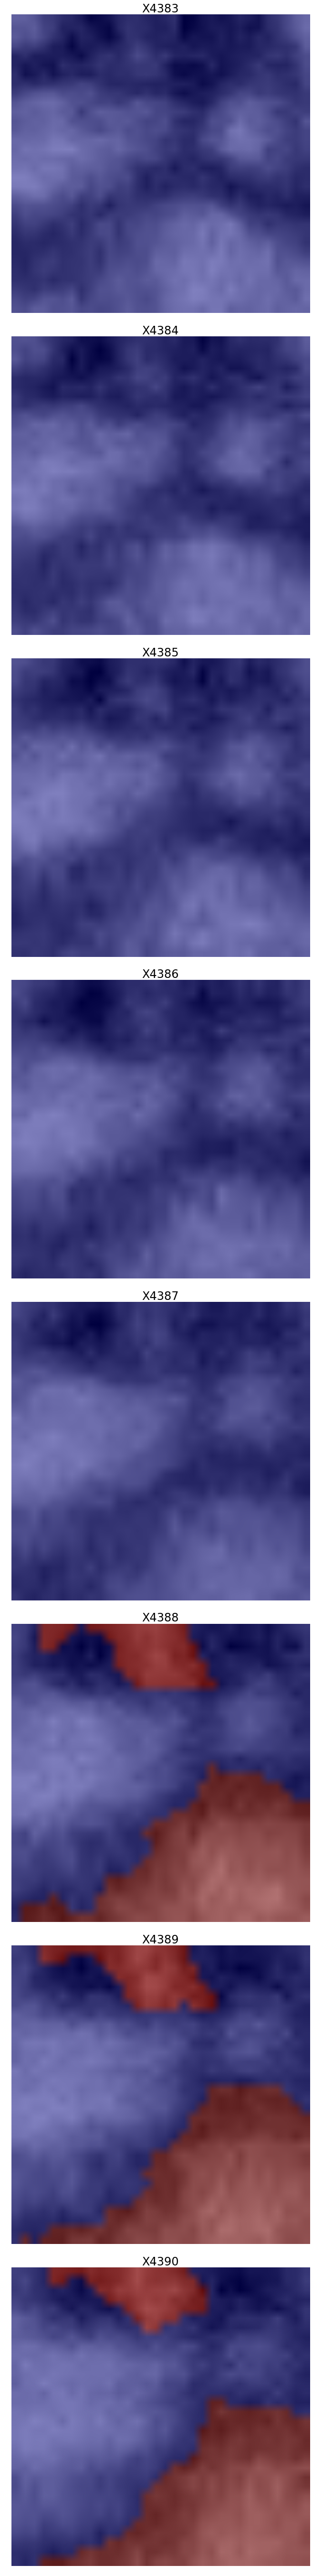

In [14]:
# Plotting several images from the array
plt.figure(figsize=(75, 75))

pic_num = 8  # <-- change the value like 1 ~ 31
if pic_num < 4:
    pic_num_even = pic_num
    pic_num_odd = 1
else:
    pic_num_even = pic_num // 2
    pic_num_odd = pic_num // 2 + (pic_num % 2)

for i in range(pic_num):
#     plt.subplot(pic_num_even, pic_num_odd, i+1)
    plt.subplot(pic_num_even + pic_num_odd, 1, i+1)
    plt.imshow(syn_gry[:, :, i], cmap='gray')
    plt.imshow(syn_gt[:, :, i], alpha=0.5)

    plt.axis('off')
    plt.title('X{}'.format(syn_x+ i * 1), fontsize=24)
    
plt.tight_layout()
plt.show()

# 3D rendering (32 x 32 x 32 synapse cube)
## 1. Mayavi
Myavi is very easy, but it can't visualize too large dataset

In [15]:
if os.path.exists("./save/syn_gry.dmp"):
    data = load_object(syn_gry)
    print("complete loading syn_gry")
else:
    save_object(syn_gry)
    data = syn_gry
    print("complete saving syn_gry")

complete loading syn_gry


In [16]:
from mayavi import mlab
# conda install -c anaconda mayavi 

src = mlab.pipeline.scalar_field(data)
outer = mlab.pipeline.iso_surface(src)
if os.path.exists("./img/syn_gry.png")!=True:
    mlab.savefig(filename='./img/syn_gry.png')
mlab.show()

![title](./img/syn_gry.png)

## 2. Paraview
Paraview is open source visualization program  
Paraview can open the file type like ".vtr", ".vtk", ....  
Download link : https://www.paraview.org/download/  
Reference : https://www.slideshare.net/SwissHUG/astro-viz-ibm 
 
.vtr :  
It is easy to make np.array to .vtr and compressed well  
but if you have large np.array data, it's not possible to

.vtk :  
It take a longer time to convert np.array to .vtk and is less compact than vrs  
but it can process larger np.array data  
  
### 2.1 Make np.array to .vtr

In [19]:
from pyevtk.hl import gridToVTK
"""
Reference : https://www.youtube.com/watch?v=o7420QY5BN0
            https://www.kaggle.com/ironbar/saving-3d-files-to-vtr-for-later-visualization/
After preparing data.vtr, run pavaview and open the data.vtr

"""
# pip install pyevtk
def save_to_vtk(data, filepath):
    """
    save the 3d data to a .vtk file. 
    
    Parameters
    ------------
    data : 3d np.array
        3d matrix that we want to visualize
    filepath : str
        where to save the vtk model, do not include vtk extension, it does automatically
    """
    x = np.arange(data.shape[0]+1)
    y = np.arange(data.shape[1]+1)
    z = np.arange(data.shape[2]+1)
    gridToVTK(filepath, x, y, z, cellData={'data':data.copy()})

if os.path.exists("./save/syn_gry.vtr"):
    save_to_vtk(syn_gry, './save/syn_gry.vtr')

<img src="./img/syn_gry_para.png" alt="Drawing" style="width: 400px;"/>

# 3D rendering (1024 x 1024 x 1024 raw data cube)
## Save too large np.array data
np.array(1024 X 1024 X 1024) is too large  
so we have to save it to ".hdf" form   
next, we load .hdf and make loaded .hdf to np.array 

In [24]:
import h5py
# conda install -c anaconda h5py
"""
Reference : https://stackoverflow.com/questions/27710245/is-there-an-analysis-speed-or-memory-usage-advantage-to-using-hdf5-for-large-arr
Saving 'thousand_gry' as np.array-from, its size is 2.7GB
but saving 'thousand_gry' as hdf-from, its size is 1.1GB
"""
def hdf_read(keyword):
    f = h5py.File('./save/'+keyword+'.hdf', 'r')
    return f[keyword]

if os.path.exists("./save/thousand_gry.hdf"):
    thousnad_gry = []
    data = np.array(hdf_read('thousand_gry'))
    print("complete loading thousand_gry")
else:
    thousand_gry = grayscale[z_start:z_start + 1024, y_start:y_start + 1024, x_start_from:x_start_from + 1024]
    with h5py.File("./save/thousand_gry.hdf", "w") as outfile:
        dset = outfile.create_dataset('thousand_gry', data=data, chunks=True)
    data = thousand_gry
    print("complete saving thousand_gry")
    
# print(data)

complete loading thousand_gry


## Make np.array to .vtk  

In [23]:
"""
##!#!#!# Caution #!#!#!##
If you run this code, you will be wait long time
as you want to run this, unannotate last line
'thousand_gry.vtk' is 10.0GB
"""
from tvtk.api import tvtk, write_data
# conda install -c anaconda mayavi 

grid = tvtk.ImageData(spacing=(1,1,1), origin=(0, 0, 0), dimensions=data.shape)
grid.point_data.scalars = data.ravel()
grid.point_data.scalars.name = 'thousand_gry'

# write_data(grid, './save/thousand_gry.vtk')

## Visualize 'thousand_gry.vtk' using Paraview
Reference : https://blog.kitware.com/dataset-resampling-filters/    
After opening 'thousand_gry.vtk', You should be resampling the file  
we can't use 'Resample with Dataset' so choose 'Resample to Image'  
I resampled the file by (300 x 300 x 300)

   <tr>
    <td>slice_contour<img src="./img/slice_contour_1.png" alt="Drawing" style="width: 400px;"/> </td>
    <td>contour<img src="./img/contour1.png" alt="Drawing" style="width: 400px;"/> </td>
    </tr>

  <tr>
    <td>threshold_0_82<img src="./img/threshold_0_82.png" alt="Drawing" style="width: 300px;"/> </td>
    <td>threshold_82_100<img src="./img/threshold_82_100.png" alt="Drawing" style="width: 300px;"/> </td>
    </tr>
  <tr>
    <td>threshold_100_140<img src="./img/threshold_100_140.png" alt="Drawing" style="width: 300px;"/> </td>
    <td>threshold_141_170<img src="./img/threshold_141_170.png" alt="Drawing" style="width: 300px;"/> </td>
    <td>threshold_170_224<img src="./img/threshold_170_224.png" alt="Drawing" style="width: 300px;"/> </td>
    </tr>

![title](./img/thousand_gry_animation.gif)